In [63]:
import numpy as np
import pandas as pd
import torch
from torch import nn,optim
from torch.utils.data import random_split,DataLoader, TensorDataset
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [19]:
device='cuda' if torch.cuda.is_available() else 'cpu'      

In [20]:
df=pd.read_csv("/kaggle/input/elevator-predictive-maintenance-dataset/predictive-maintenance-dataset.csv")

In [21]:
df.head()

,ID,revolutions,humidity,vibration,x1,x2,x3,x4,x5
0,1,93.744,73.999,18.0,167.743,19.745,1.266828,8787.937536,5475.852001
1,2,93.740,73.999,18.0,167.739,19.741,1.266774,8787.187600,5475.852001
2,3,93.736,73.998,18.0,167.734,19.738,1.266737,8786.437696,5475.704004
3,4,93.732,73.998,18.0,167.730,19.734,1.266683,8785.687824,5475.704004
4,5,93.729,73.998,18.0,167.727,19.731,1.266642,8785.125441,5475.704004


In [22]:
temp_data=[np.array((row['x1'],row['x2'],row['x3'],row['x4'],row['x5']))for _,row in df.iterrows()]

In [23]:
temp_data[0]

array([1.67743000e+02, 1.97450000e+01, 1.26682793e+00, 8.78793754e+03,
       5.47585200e+03])

In [24]:
def split_data(data,ratio=0.7):
    train_size = int(ratio * len(data))
    test_size = len(data) - train_size
    
    train_data, test_data = random_split(data, [train_size, test_size])
    
    return torch.tensor(train_data,dtype=torch.float32).to(device),torch.tensor(test_data,dtype=torch.float32).to(device)

In [25]:
train_data,test_data=split_data(temp_data)

In [26]:
batch_size = 5000
train_dataset = TensorDataset(train_data, train_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [27]:
class Rnn_layer(nn.Module):
    def __init__(self,input_len, hidden_size, num_layers,output_size):
        super(Rnn_layer,self).__init__()
        
        self.num_layers=num_layers
        self.hidden_size=hidden_size
        
        self.lstm=nn.LSTM(
            input_size=input_len,
            hidden_size=hidden_size,
            num_layers=num_layers
        )
        self.dropout = nn.Dropout(0.5)
        self.linear=nn.Linear(hidden_size,output_size)
    
    def forward(self,X):
        hidden_states = torch.zeros(self.num_layers, self.hidden_size).to(device)
        cell_states = torch.zeros(self.num_layers, self.hidden_size).to(device)
        out, _ = self.lstm(X, (hidden_states, cell_states))
        out = self.dropout(out)
        out = torch.relu(out)
        out = self.linear(out)
        
        return out

In [28]:
class Autoencoder(nn.Module):
    def __init__(self, input_len, hidden_size, num_layers,encoder_output_size):
        super(Autoencoder, self).__init__()
        
        self.encoder = Rnn_layer(input_len, hidden_size, num_layers,encoder_output_size).to(device)
        self.decoder = Rnn_layer(encoder_output_size,hidden_size, num_layers,input_len).to(device)
    
    def forward(self, x):
        x = self.encoder(x)
        x = torch.relu(x)
        x = self.decoder(x)
        
        return x

In [29]:
def train(num_epochs, model, train_data, loss_func, optimizer):
    for epoch in range(num_epochs):
        for i,(data, labels) in enumerate(train_data):
            output = model(data)
            loss = loss_func(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i+1==len(train_data) and epoch%10==0:
                print(f"Epoch: {epoch}; Loss: {loss.item():>4f}")

In [30]:
input_len=len(temp_data[0])
hidden_size=8
num_layers=1
output_len=2

In [31]:
model = Autoencoder(input_len, hidden_size, num_layers,output_len)
print(model)

Autoencoder(
  (encoder): Rnn_layer(
    (lstm): LSTM(5, 8)
    (dropout): Dropout(p=0.5, inplace=False)
    (linear): Linear(in_features=8, out_features=2, bias=True)
  )
  (decoder): Rnn_layer(
    (lstm): LSTM(2, 8)
    (dropout): Dropout(p=0.5, inplace=False)
    (linear): Linear(in_features=8, out_features=5, bias=True)
  )
)


In [32]:
loss_func = nn.MSELoss()
adam = optim.Adam(model.parameters(), lr=0.005,weight_decay=1e-5)

In [33]:
len(train_loader)

16

In [34]:
train(2000 ,model, train_loader, loss_func, adam)

Epoch: 0; Loss: 8102659.000000
Epoch: 10; Loss: 8057774.500000
Epoch: 20; Loss: 7984203.500000
Epoch: 30; Loss: 7961930.000000
Epoch: 40; Loss: 7999058.500000
Epoch: 50; Loss: 7954018.000000
Epoch: 60; Loss: 7957898.000000
Epoch: 70; Loss: 7925102.500000
Epoch: 80; Loss: 7982634.000000
Epoch: 90; Loss: 7943230.000000
Epoch: 100; Loss: 7831418.500000
Epoch: 110; Loss: 7916815.500000
Epoch: 120; Loss: 7835502.500000
Epoch: 130; Loss: 7842827.500000
Epoch: 140; Loss: 7863700.500000
Epoch: 150; Loss: 7851333.000000
Epoch: 160; Loss: 7830827.500000
Epoch: 170; Loss: 7831833.000000
Epoch: 180; Loss: 7801138.500000
Epoch: 190; Loss: 7828057.000000
Epoch: 200; Loss: 7763470.000000
Epoch: 210; Loss: 7728451.500000
Epoch: 220; Loss: 7732693.000000
Epoch: 230; Loss: 7774689.000000
Epoch: 240; Loss: 7691631.000000
Epoch: 250; Loss: 7787735.500000
Epoch: 260; Loss: 7682355.000000
Epoch: 270; Loss: 7681962.000000
Epoch: 280; Loss: 7647990.000000
Epoch: 290; Loss: 7690598.500000
Epoch: 300; Loss: 765

In [36]:
model_path = "model.pth"

torch.save(model, model_path)

In [83]:
def find_anomaly(model,test_data,loss_func):
    loss=[]
    with torch.no_grad():
        preds=model(test_data)
        for i,pred in enumerate(preds):
            loss.append(loss_func(pred,test_data[i]).item())
        
        anomaly=torch.zeros(len(preds))
        
        loss=torch.tensor(loss,dtype=torch.float32)
        mean = torch.mean(loss)
        std_dev = torch.std(loss)
        
        threshold=mean+2*std_dev
        
        for i,val in enumerate(loss):
            if val>threshold:
                anomaly[i]=1
        
        return anomaly

In [85]:
anomaly=find_anomaly(model,test_data[:200],loss_func)
anomaly

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [86]:
vibration=[]
for i in range(len(anomaly)):
    for _,row in df.iterrows():
        if row['x1']==test_data[i][0] and row['x2']==test_data[i][1] and row['x3']==test_data[i][2] and row['x4']==test_data[i][3] and row['x5']==test_data[i][4]:
            vibration.append(row['vibration'])
            break
anomaly_forcasted=[None]*len(anomaly)
for i,val in enumerate(anomaly):
    if val==1:
        anomaly_forcasted[i]=vibration[i]

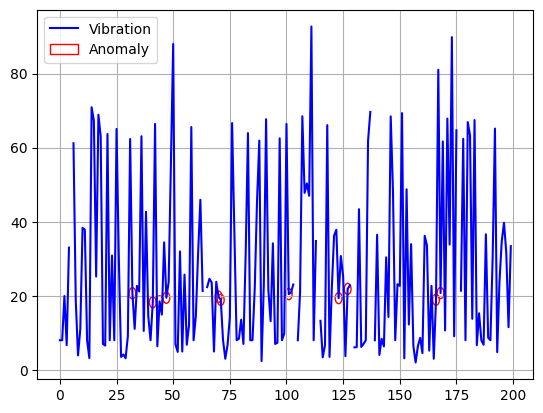

In [87]:
y=vibration
x=[i for i in range(len(vibration))]
plt.plot(y,linestyle='-',label='Vibration', color='blue')
ax = plt.gca()  
label_added=False
for i,point in enumerate(anomaly):
    if point!=0:
        circle = Circle((x[i], y[i]), radius=1.5,edgecolor='red', facecolor='none')
        ax.add_patch(circle)
        if label_added==False:
            circle.set_label('Anomaly')
            label_added=True

plt.legend()
plt.grid(True)